In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/Users/daniyalrosli/Customer-Creditworthiness-Prediction-Using-Machine-Learning/credit_risk_dataset.csv')

In [5]:
#understanding the data

print(df.head())
print(df.info())
print(df.describe())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


In [14]:
from sklearn.preprocessing import StandardScaler

# Make a copy of the original dataframe
df_clean = df.copy()

# Handle missing values
df_clean['person_emp_length'].fillna(df_clean['person_emp_length'].median(), inplace=True)
df_clean['loan_int_rate'].fillna(df_clean['loan_int_rate'].median(), inplace=True)

# Convert categorical variables to numeric using one-hot encoding
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df_clean = pd.get_dummies(df_clean, columns=categorical_columns, drop_first=True)

# Scale numerical features using StandardScaler
scaler = StandardScaler()

numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

df_clean[numerical_columns] = scaler.fit_transform(df_clean[numerical_columns])

# Remove any potential duplicate rows
df_clean = df_clean.drop_duplicates()

# Display info about the cleaned dataset
print("Cleaned dataset info:")
print(df_clean.info())
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())







Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   person_age                   32416 non-null  float64
 1   person_income                32416 non-null  float64
 2   person_emp_length            32416 non-null  float64
 3   loan_amnt                    32416 non-null  float64
 4   loan_int_rate                32416 non-null  float64
 5   loan_status                  32416 non-null  int64  
 6   loan_percent_income          32416 non-null  float64
 7   cb_person_cred_hist_length   32416 non-null  float64
 8   person_home_ownership_OTHER  32416 non-null  bool   
 9   person_home_ownership_OWN    32416 non-null  bool   
 10  person_home_ownership_RENT   32416 non-null  bool   
 11  loan_intent_EDUCATION        32416 non-null  bool   
 12  loan_intent_HOMEIMPROVEMENT  32416 non-null  bool   
 13 

In [16]:
#feature engineering

# Create interaction features
df_clean['income_per_age'] = df_clean['person_income'] * df_clean['person_age']
df_clean['debt_to_income'] = df_clean['loan_amnt'] / df_clean['person_income']
df_clean['payment_to_income'] = df_clean['loan_int_rate'] * df_clean['loan_percent_income']

# Create polynomial features for important numerical variables
df_clean['age_squared'] = df_clean['person_age'] ** 2
df_clean['income_squared'] = df_clean['person_income'] ** 2

# Create risk score feature
df_clean['risk_score'] = (df_clean['loan_int_rate'] * df_clean['loan_percent_income'] * 
                         df_clean['cb_person_default_on_file_Y'].astype(int))

# Binning age into categories
df_clean['age_group'] = pd.qcut(df_clean['person_age'], q=5, labels=['Very Young', 'Young', 'Middle', 'Senior', 'Elder'])

# Print the new features
print("New features added:")
print(df_clean[['income_per_age', 'debt_to_income', 'payment_to_income', 
                'age_squared', 'income_squared', 'risk_score']].head())

New features added:
   income_per_age  debt_to_income  payment_to_income  age_squared  \
0        0.103430      -35.138916           6.380241     0.818067   
1        0.967284        1.492105          -0.026739     1.127529   
2        0.393824        0.710793           2.252291     0.186907   
3        0.007127     -421.188938           4.605176     0.558143   
4        0.111178      -21.313738           3.754109     0.347756   

   income_squared  risk_score  
0        0.013077    6.380241  
1        0.829813   -0.000000  
2        0.829813    0.000000  
3        0.000091    0.000000  
4        0.035544    3.754109  


In [17]:
#check data after cleaning and feature engineering

print(df_clean.head())
print(df_clean.info())
print(df_clean.describe())



   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0   -0.904471      -0.114354          28.904903   4.018287       1.623527   
1   -1.061852      -0.910941           0.056504  -1.359219       0.040655   
2   -0.432327      -0.910941          -0.921408  -0.647491       0.601796   
3   -0.747089      -0.009540          -0.187974   4.018287       1.367283   
4   -0.589708      -0.188530           0.789938   4.018287       1.055898   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1             3.929865                   -0.692614   
1            0            -0.657707                   -0.938982   
2            1             3.742617                   -0.692614   
3            1             3.368121                   -0.938982   
4            1             3.555369                   -0.446246   

   person_home_ownership_OTHER  person_home_ownership_OWN  ...  loan_grade_F  \
0                        False                      Fa

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

#model development

# Split features and target
X = df_clean.drop(['loan_status', 'age_group'], axis=1)
y = df_clean['loan_status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train multiple models

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    print(f"{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("Classification Report:")
    print(results[name]['classification_report'])
    print("Confusion Matrix:")
    print(results[name]['confusion_matrix'])



Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.8680
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5073
           1       0.78      0.55      0.65      1411

    accuracy                           0.87      6484
   macro avg       0.83      0.75      0.78      6484
weighted avg       0.86      0.87      0.86      6484

Confusion Matrix:
[[4850  223]
 [ 633  778]]

Training Random Forest...
Random Forest Results:
Accuracy: 0.9315
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5073
           1       0.96      0.72      0.82      1411

    accuracy                           0.93      6484
   macro avg       0.94      0.85      0.89      6484
weighted avg       0.93      0.93      0.93      6484

Confusion Matrix:
[[5027   46]
 [ 398 1013]]

Training XGBoost...
XGBoost Results:
Accuracy: 0.9374
Classific

In [23]:
#hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Define hyperparameters for each model

# Logistic Regression hyperparameters

log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Random Forest hyperparameters

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9]
}

# XGBoost hyperparameters

xgb_params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.3]
}

# Create hyperparameters dictionary

params = {
    'Logistic Regression': log_reg_params,
    'Random Forest': rf_params,
    'XGBoost': xgb_params
}

# Initialize GridSearchCV objects

grid_searches = {}
for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    grid_searches[name] = GridSearchCV(model, params[name], cv=5, n_jobs=-1)
    grid_searches[name].fit(X_train, y_train)
    print(f"Best parameters: {grid_searches[name].best_params_}")
    print(f"Best score: {grid_searches[name].best_score_:.4f}")

# Evaluate models with best parameters

best_results = {}
for name, model in grid_searches.items():
    y_pred = model.predict(X_test)
    
    # Store results
    best_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }
    
    print(f"{name} Results:")
    print(f"Accuracy: {best_results[name]['accuracy']:.4f}")
    print("Classification Report:")
    print(best_results[name]['classification_report'])
    print("Confusion Matrix:")
    print(best_results[name]['confusion_matrix'])

# Feature importance

# Extract feature importances from the Random Forest model

rf_model = grid_searches['Random Forest'].best_estimator_

feature_importances = rf_model.feature_importances_

# Create a dataframe to display feature importances
features_df = pd.DataFrame({'Features': X.columns, 'Importance': feature_importances})

# Sort features by importance

features_df = features_df.sort_values('Importance', ascending=False)

# Display the most important features

print("Feature importances:")

print(features_df.head(10))

# Plot feature importances

plt.figure(figsize=(10, 6))

plt.barh(features_df['Features'][:10], features_df['Importance'][:10])

plt.xlabel("Importance")

plt.title("Feature Importances")

plt.show()



Running GridSearchCV for Logistic Regression...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.0 when using version 1.6.1. This might l

Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.8660
Running GridSearchCV for Random Forest...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.0 when using version 1.6.1. 

Best parameters: {'max_depth': 9, 'n_estimators': 200}
Best score: 0.9191
Running GridSearchCV for XGBoost...


AttributeError: 'super' object has no attribute '__sklearn_tags__'

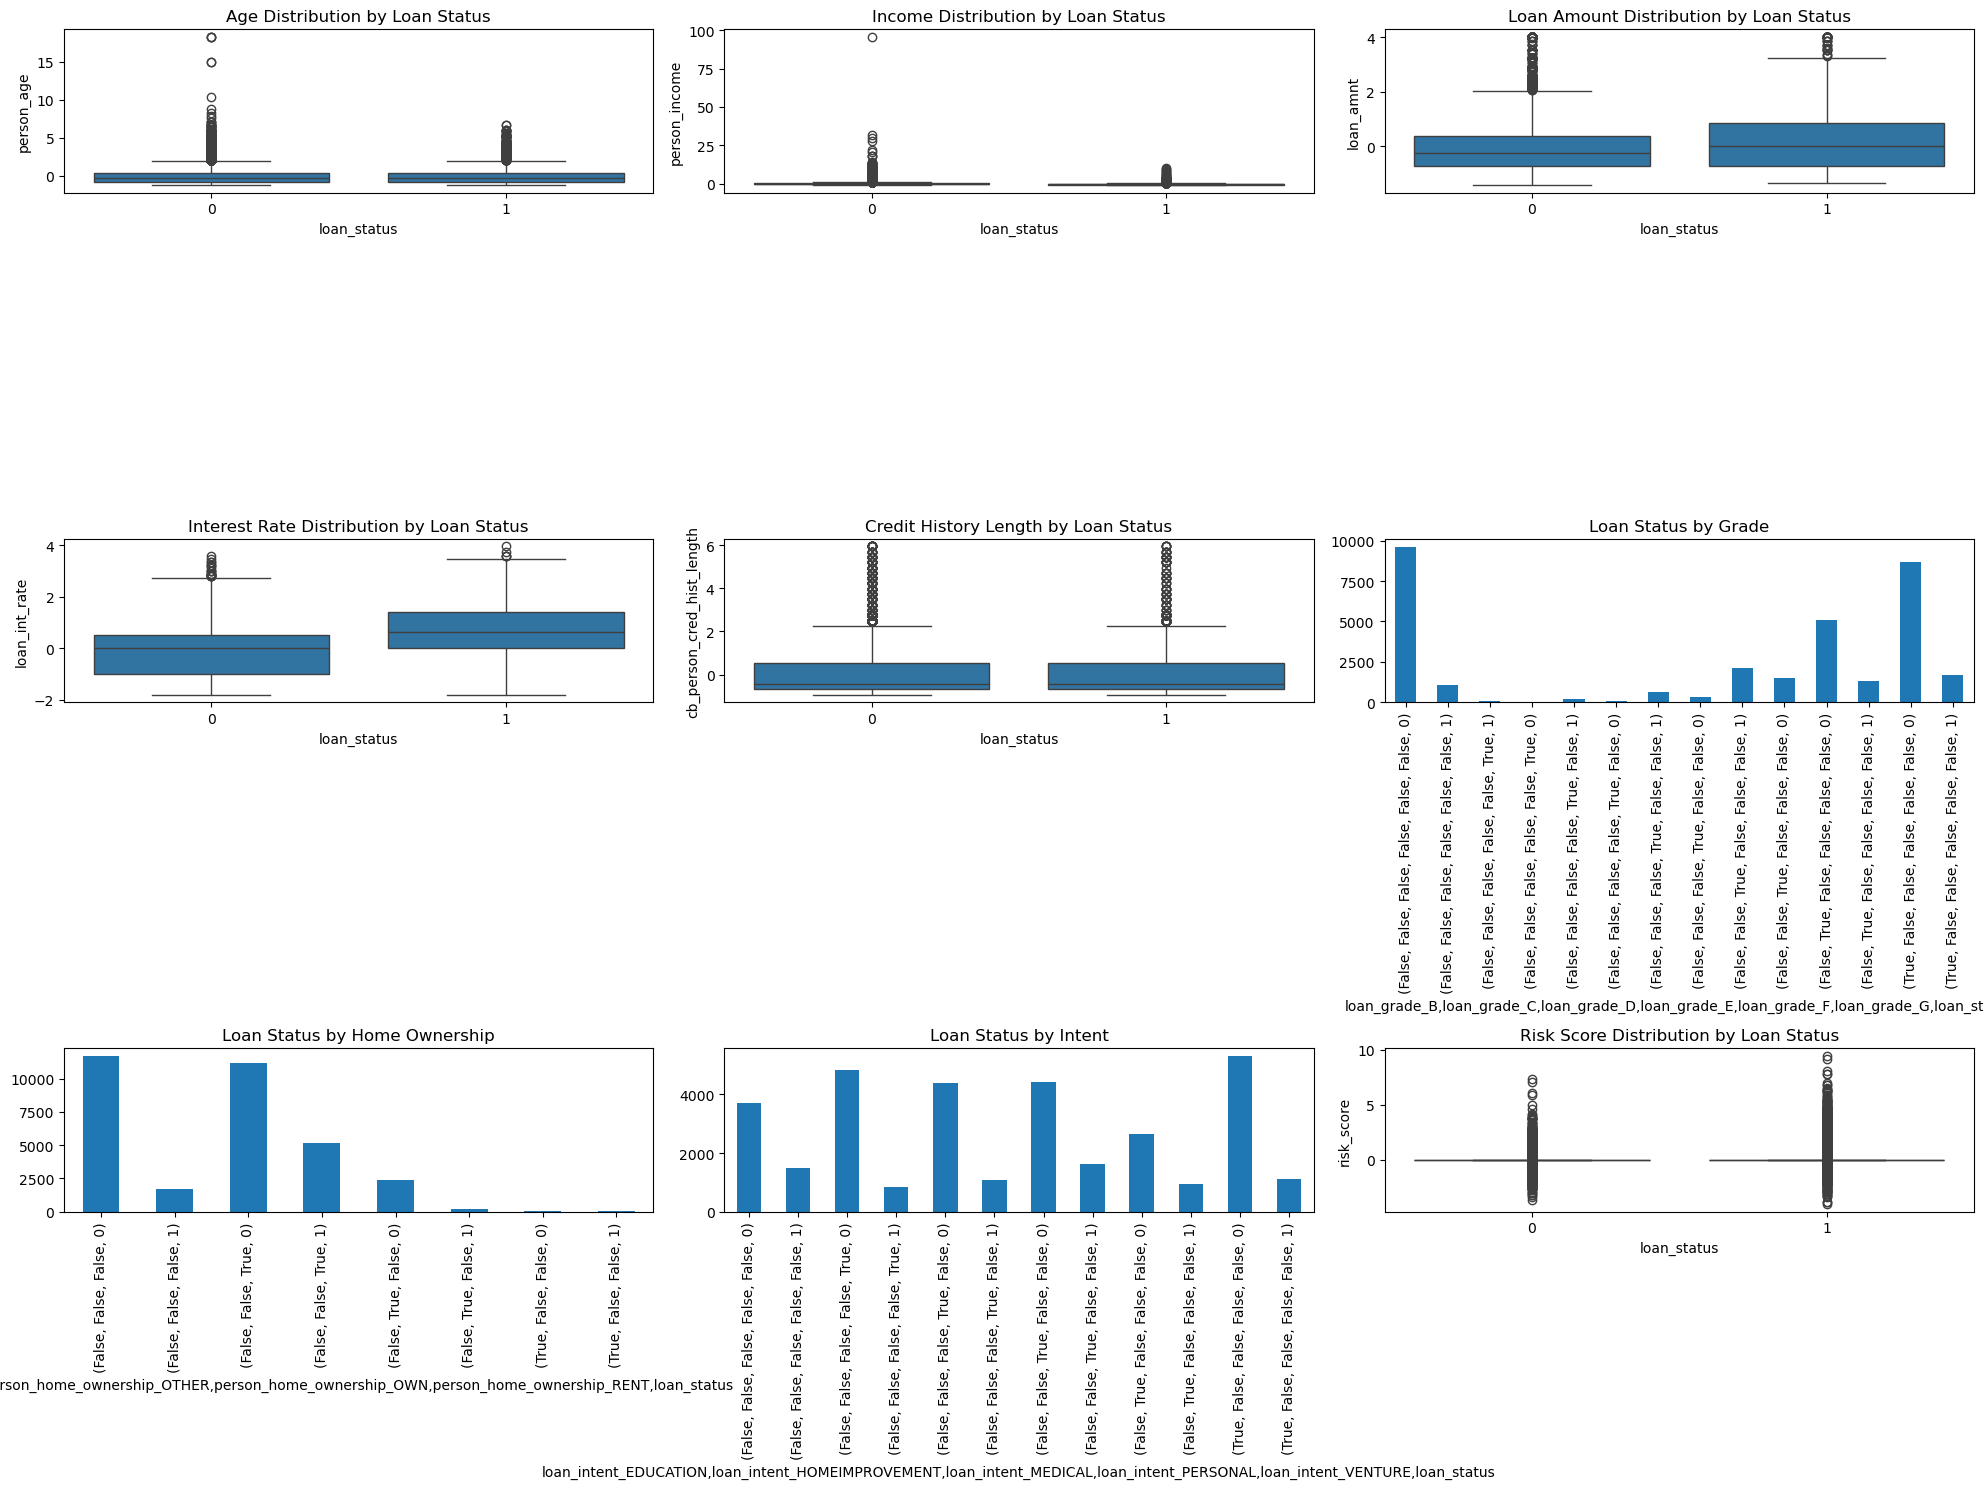

In [25]:
# full data visualization

import seaborn as sns

# Create subplots for visualizing different aspects of the data
plt.figure(figsize=(20, 15))

# 1. Age distribution by loan status
plt.subplot(331)
sns.boxplot(x='loan_status', y='person_age', data=df_clean)
plt.title('Age Distribution by Loan Status')

# 2. Income distribution by loan status
plt.subplot(332)
sns.boxplot(x='loan_status', y='person_income', data=df_clean)
plt.title('Income Distribution by Loan Status')

# 3. Loan amount distribution by loan status
plt.subplot(333)
sns.boxplot(x='loan_status', y='loan_amnt', data=df_clean)
plt.title('Loan Amount Distribution by Loan Status')

# 4. Interest rate distribution by loan status
plt.subplot(334)
sns.boxplot(x='loan_status', y='loan_int_rate', data=df_clean)
plt.title('Interest Rate Distribution by Loan Status')

# 5. Credit history length distribution
plt.subplot(335)
sns.boxplot(x='loan_status', y='cb_person_cred_hist_length', data=df_clean)
plt.title('Credit History Length by Loan Status')

# 6. Loan grade distribution
plt.subplot(336)
grade_counts = df_clean.groupby(['loan_grade_B', 'loan_grade_C', 'loan_grade_D', 
                               'loan_grade_E', 'loan_grade_F', 'loan_grade_G'])['loan_status'].value_counts()
grade_counts.plot(kind='bar')
plt.title('Loan Status by Grade')

# 7. Home ownership distribution
plt.subplot(337)
ownership_counts = df_clean.groupby(['person_home_ownership_OTHER', 'person_home_ownership_OWN', 
                                   'person_home_ownership_RENT'])['loan_status'].value_counts()
ownership_counts.plot(kind='bar')
plt.title('Loan Status by Home Ownership')

# 8. Loan intent distribution
plt.subplot(338)
intent_counts = df_clean.groupby(['loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 
                                'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 
                                'loan_intent_VENTURE'])['loan_status'].value_counts()
intent_counts.plot(kind='bar')
plt.title('Loan Status by Intent')

# 9. Risk score distribution
plt.subplot(339)
sns.boxplot(x='loan_status', y='risk_score', data=df_clean)
plt.title('Risk Score Distribution by Loan Status')

plt.tight_layout()
plt.show()

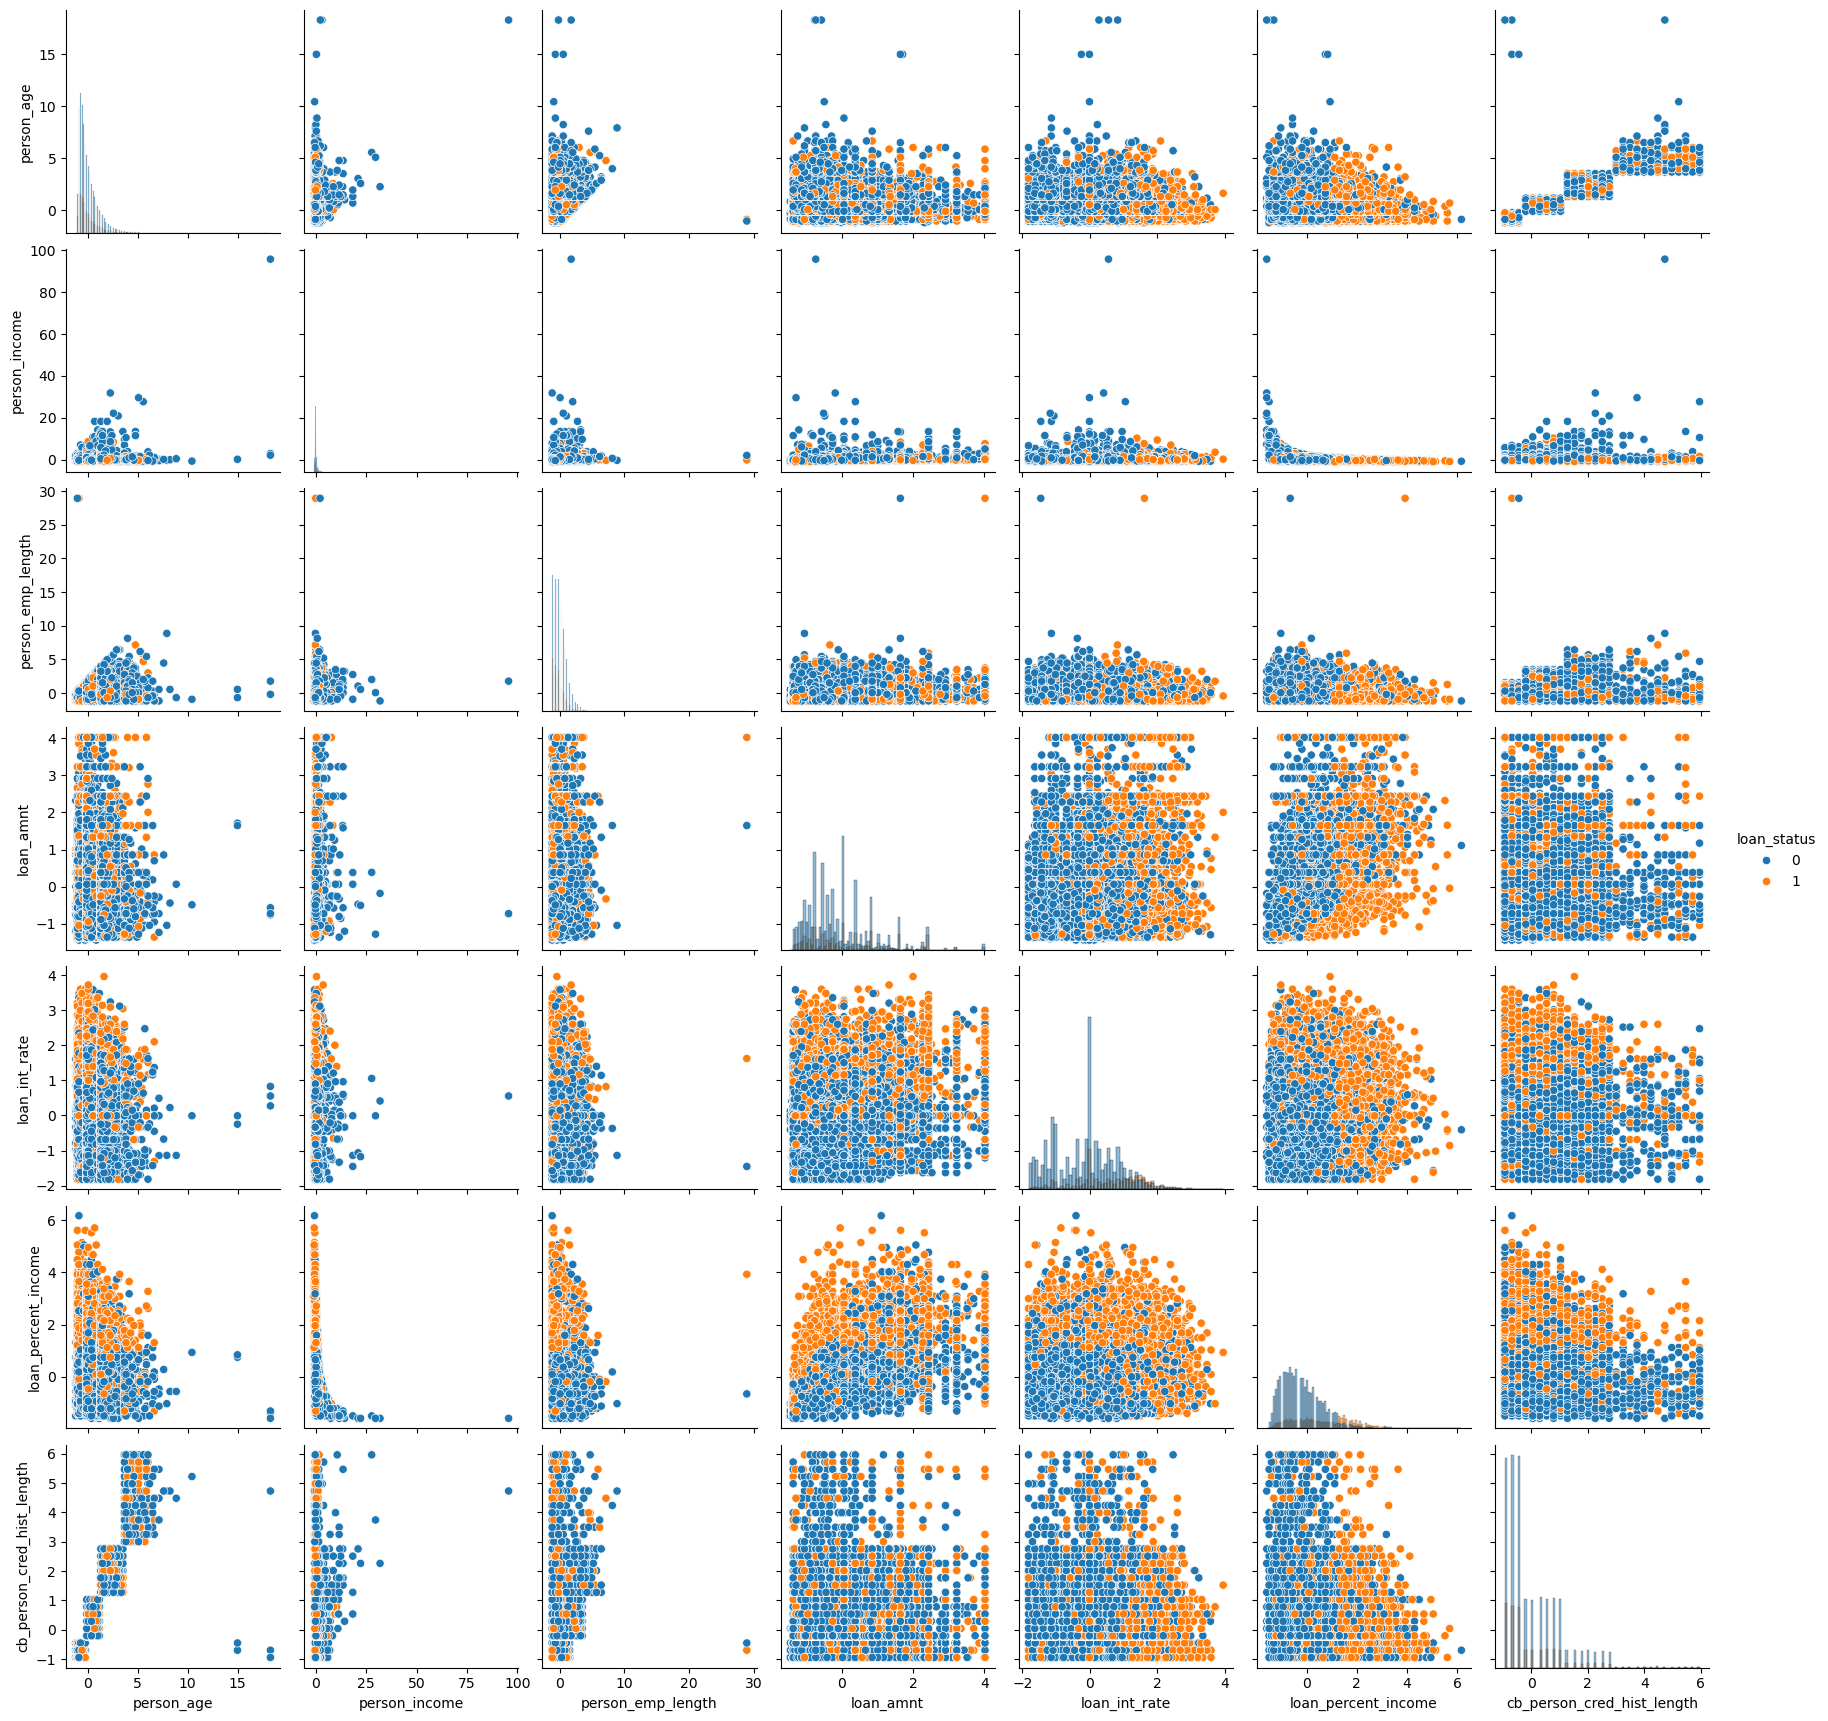

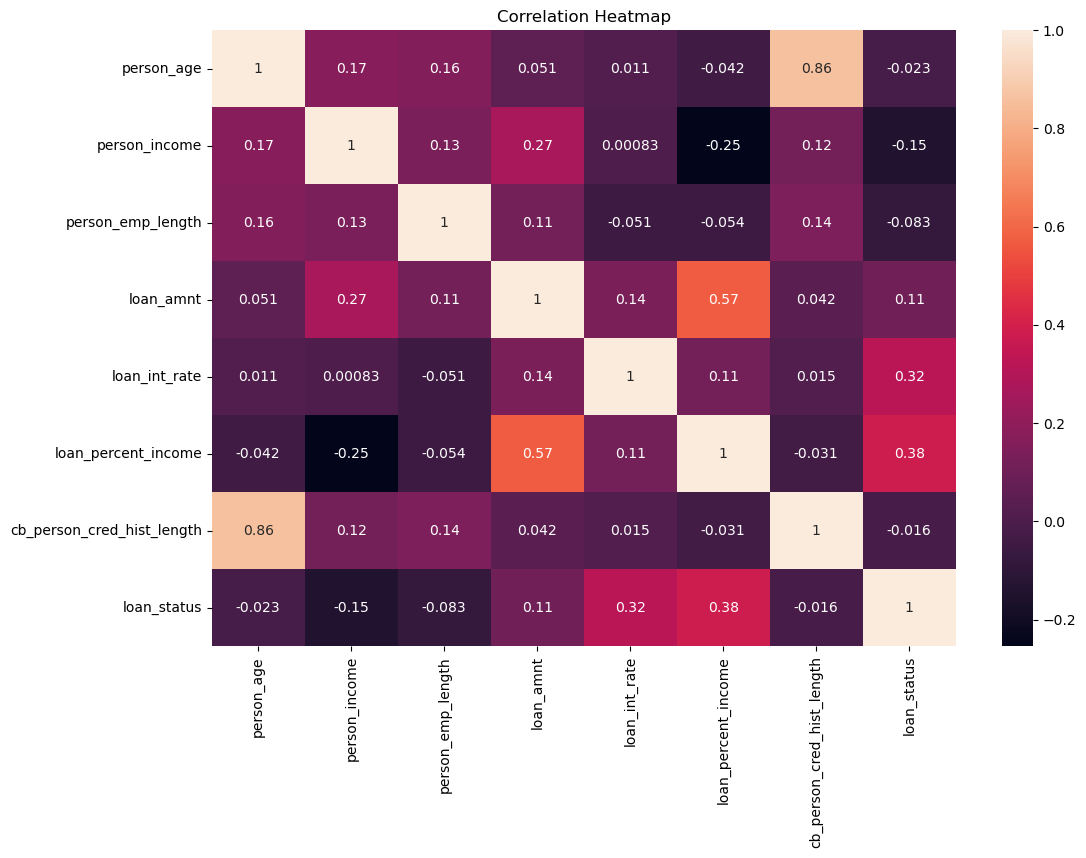

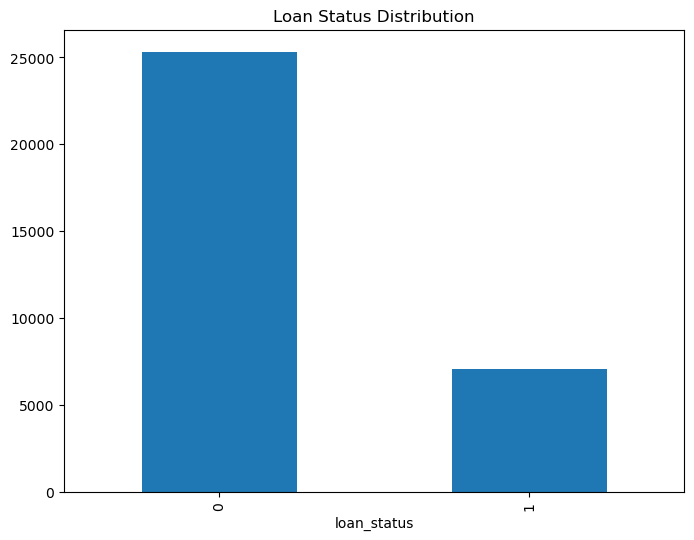

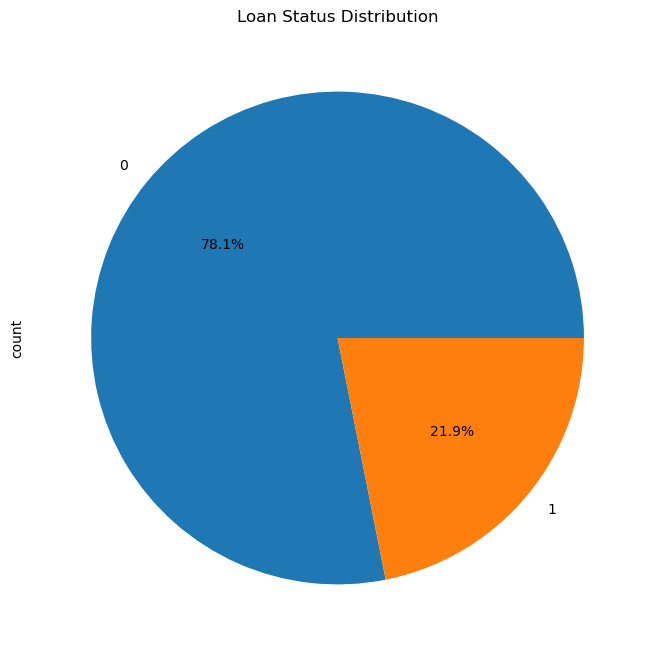

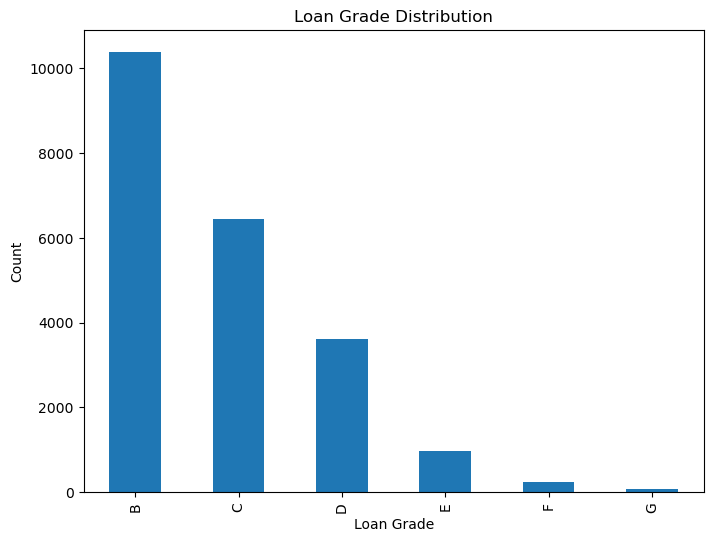

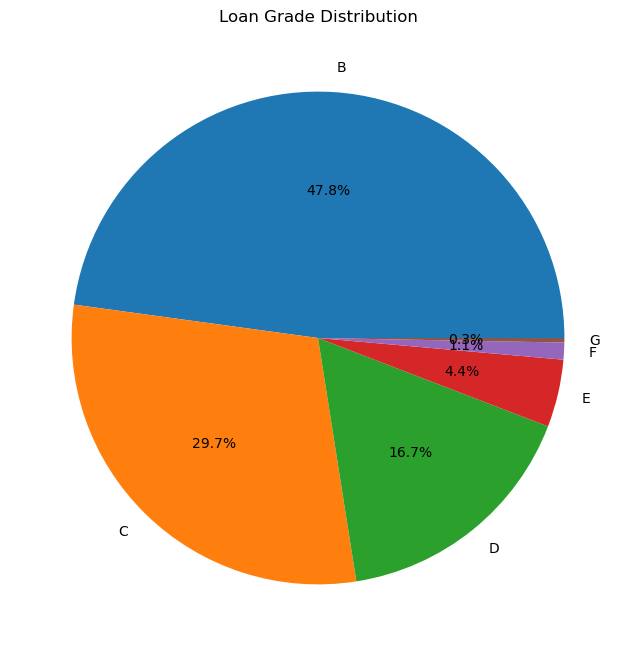

KeyError: 'loan_intent'

<Figure size 800x600 with 0 Axes>

In [28]:
#exploratory data analysis

# Create a pairplot to visualize relationships between features

sns.pairplot(df_clean[['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                          'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']],
                 hue='loan_status', diag_kind='hist')

plt.show()

# Create a heatmap to visualize correlations between features

plt.figure(figsize=(12, 8))


sns.heatmap(df_clean[['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                            'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']].corr(), annot=True)

plt.title('Correlation Heatmap')

plt.show()

# Create a bar plot to visualize the distribution of loan status

plt.figure(figsize=(8, 6))

df_clean['loan_status'].value_counts().plot(kind='bar')

plt.title('Loan Status Distribution')

plt.show()

# Create a pie chart to visualize the distribution of loan status

plt.figure(figsize=(8, 8))

df_clean['loan_status'].value_counts().plot(kind='pie', autopct='%1.1f%%')

plt.title('Loan Status Distribution')

plt.show()


# Create a bar plot to visualize the distribution of loan grades
plt.figure(figsize=(8, 6))

grade_columns = ['loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G']
grade_counts = df_clean[grade_columns].sum()
grade_counts.index = [col.replace('loan_grade_', '') for col in grade_counts.index]
grade_counts.plot(kind='bar')

plt.title('Loan Grade Distribution')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.show()

# Create a pie chart to visualize the distribution of loan grades
plt.figure(figsize=(8, 8))

grade_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Loan Grade Distribution')
plt.ylabel('')
plt.show()

# Create a bar plot to visualize the distribution of loan intents

plt.figure(figsize=(8, 6))

df_clean['loan_intent'].value_counts().plot(kind='bar')

plt.title('Loan Intent Distribution')

plt.show()

# Create a pie chart to visualize the distribution of loan intents


plt.figure(figsize=(8, 8))

df_clean['loan_intent'].value_counts().plot(kind='pie', autopct='%1.1f%%')

plt.title('Loan Intent Distribution')

plt.show()

# Create a bar plot to visualize the distribution of home ownership

plt.figure(figsize=(8, 6))

df_clean['person_home_ownership'].value_counts().plot(kind='bar')

plt.title('Home Ownership Distribution')

plt.show()

# Create a pie chart to visualize the distribution of home ownership

plt.figure(figsize=(8, 8))

df_clean['person_home_ownership'].value_counts().plot(kind='pie', autopct='%1.1f%%')

plt.title('Home Ownership Distribution')

plt.show()

# Create a bar plot to visualize the distribution of credit history lengths

plt.figure(figsize=(8, 6))

df_clean['cb_person_cred_hist_length'].value_counts().plot(kind='bar')

plt.title('Credit History Length Distribution')


plt.show()

# Create a pie chart to visualize the distribution of credit history lengths

plt.figure(figsize=(8, 8))

df_clean['cb_person_cred_hist_length'].value_counts().plot(kind='pie', autopct='%1.1f%%')

plt.title('Credit History Length Distribution')

plt.show()

# Create a bar plot to visualize the distribution of default history

plt.figure(figsize=(8, 6))


df_clean['cb_person_default_on_file'].value_counts().plot(kind='bar')

plt.title('Default History Distribution')

plt.show()


# Create a pie chart to visualize the distribution of default history

plt.figure(figsize=(8, 8))

df_clean['cb_person_default_on_file'].value_counts().plot(kind='pie', autopct='%1.1f%%')

plt.title('Default History Distribution')


plt.show()



